In [1]:
# Run grid search for autoencoder.
# NOTE: the hyperparemeter search space is defined in grid_search.py
!python grid_search.py

CPU count: 10
Total number of combinations: 48
Sequences duplicates : 2327212/2357292 || 98.72395952643967%
Sequences duplicates : 2327212/2357292 || 98.72395952643967%
Sequences duplicates : 2327212/2357292 || 98.72395952643967%
Sequences duplicates : 2327212/2357292 || 98.72395952643967%
Sequences duplicates : 2327212/2357292 || 98.72395952643967%
Sequences duplicates : 1886/4502 || 41.89249222567747%
Sequences duplicates : 981/3471 || 28.262748487467587%Sequences duplicates : 1886/4502 || 41.89249222567747%

Sequences duplicates : 806/4246 || 18.982571832312765%
Sequences duplicates : 981/3471 || 28.262748487467587%
Sequences duplicates : 595/3244 || 18.341553637484587%
Sequences duplicates : 806/4246 || 18.982571832312765%
Sequences duplicates : 1886/4502 || 41.89249222567747%
Sequences duplicates : 595/3244 || 18.341553637484587%
Sequences duplicates : 1789/5391 || 33.18493785939528%
Sequences duplicates : 1886/4502 || 41.89249222567747%
Sequences duplicates : 981/3471 || 28.26274

## Load trained model

In [2]:
from Autoencoder import Autoencoder
import torch
import json

# extract autoencoder info from json file
with open('trained_models/model_0_info.json') as f:
    training_params = json.load(f)
    print(training_params)


num_system_calls = 174
# initiate autoencoder model
model = Autoencoder(training_params['sequence_length'], num_system_calls, training_params['embedding_dim'], training_params['encoding_dim'], training_params['hidden_dim']) 

# load trained weights of best model
model.load_state_dict(torch.load('trained_models/model_0.pth')) # load trained weights of best model

{'train_loss': 0.07920616817175809, 'attack_loss': 1.1032921033725078, 'val_loss': 0.08042016896617961, 'atk_val_ratio': 9.618640714444632, 'hidden_dim': 8, 'embedding_dim': 10, 'encoding_dim': 3, 'batch_size': 64, 'learning_rate': 0.01, 'sequence_length': 20, 'total_epochs': 60}


<All keys matched successfully>

In [ ]:
from grid_search_helper import load_all_attack_data, attack_test
from IPython.display import clear_output
import torch.nn as nn
%load_ext autoreload
%reload_ext autoreload
clear_output()


# loss threshold for anomaly/attack classification
# loss values above this threshold are considered attacks
threshold = training_params['atk_val_ratio'] * training_params['val_loss'] / 2
criterion = nn.MSELoss()
print('Attack/Validation loss ratio', training_params['atk_val_ratio'])
print('Validation loss', training_params['val_loss'])
print('Threshold', threshold)

# load and test attack data
attack_data_master_path = '../../../ADFA-LD-Dataset/ADFA-LD/Attack_Data_Master/'
attack_data_container = load_all_attack_data(attack_data_master_path, training_params['sequence_length'], training_params['batch_size'])

# time the attack test
import time
start_time = time.time()
attack_loss_history_per_folder = attack_test(model, criterion, attack_data_container, predict=True)
print('\nAttack test time:', time.time() - start_time)


# classify attacks based on loss threshold
attack_classification = {}
for folder_name, loss_history in attack_loss_history_per_folder.items():
    attack_classification[folder_name] = []
    for loss in loss_history:
        if loss > threshold:
            attack_classification[folder_name].append(1)
        else:
            attack_classification[folder_name].append(0)

# calculate accuracy of attack classification
total_attack = 0
correct_attack = 0

for folder_name, predictions in attack_classification.items():
    correct_attack += sum(predictions)
    total_attack += len(predictions)

print('Accuracy of attack classification: ', correct_attack/total_attack)

# TODO: mix attack data with normal data and test TPR and FPR of attack classification

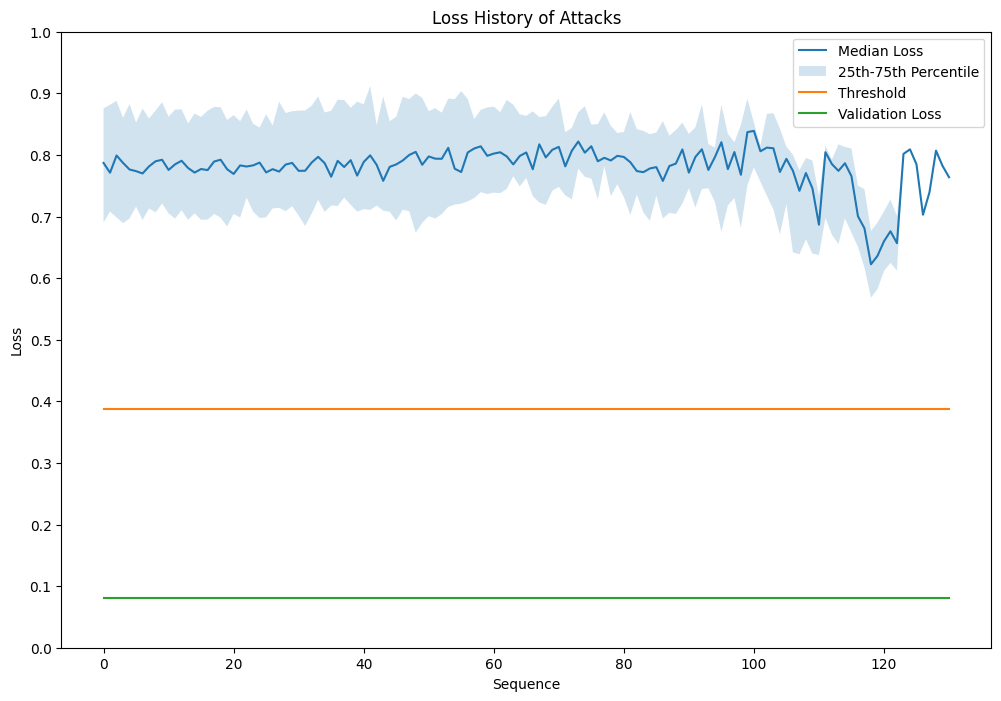

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Find the length of the longest array
max_length = max(len(loss_history) for loss_history in attack_loss_history_per_folder.values())

# Pad shorter arrays with NaN
attack_losses = [np.pad(loss_history, (0, max_length - len(loss_history)), constant_values=np.nan) for loss_history in attack_loss_history_per_folder.values()]

# Convert list of arrays to a NumPy array
attack_losses = np.array(attack_losses)

# Calculate the median, 25th percentile, and 75th percentile losses
median_loss = np.nanmedian(attack_losses, axis=0)
lower_loss = np.nanquantile(attack_losses, 0.25, axis=0)
upper_loss = np.nanquantile(attack_losses, 0.75, axis=0)

# Plot the threshold line and the validation loss line
threshold_line = np.full(max_length, threshold)
val_loss_line = np.full(max_length, training_params['val_loss'])

# Plotting
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(median_loss)), median_loss, label='Median Loss')
plt.fill_between(np.arange(len(median_loss)), lower_loss, upper_loss, alpha=0.2, label='25th-75th Percentile')
plt.plot(np.arange(len(threshold_line)), threshold_line, label='Threshold')
plt.plot(np.arange(len(val_loss_line)), val_loss_line, label='Validation Loss')
plt.legend()
plt.xlabel('Sequence')
plt.ylabel('Loss')
plt.title('Loss History of Attacks')
plt.ylim(bottom=0)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

In [5]:
torch.backends.mps.is_available()

True